<a href="https://colab.research.google.com/github/cast42/makemore_jax/blob/main/build_makemore_mlp_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

JAX implementation of [@karpathy](https://twitter.com/karpathy)'s notebook shared in the context of video [Building makemore Part 2: MLP](https://www.youtube.com/watch?v=TCH_1BHY58I). The implementation by karpathy is in Toch and implements a neural network based on [A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf).
The notebook shared by [Andrey](https://github.com/karpathy): [build_makemore_mlp.ipynb](https://colab.research.google.com/drive/1YIfmkftLrz6MPTOO9Vwqrop2Q5llHIGK?usp=sharing)

In [27]:
!pip install jax_metrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2022-11-30 13:52:47--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.2’

names.txt.2         100%[===================>] 222.80K  --.-KB/s    in 0.02s   

2022-11-30 13:52:47 (8.84 MB/s) - ‘names.txt.2’ saved [228145/228145]



In [29]:
import jax
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax_metrics as jm

from jax import grad, jit, random, value_and_grad
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [30]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [31]:
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [32]:
len(words)

32033

In [33]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [34]:
X, Y = [], []
block_size = 3
for w in words:

  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

X = jnp.array(X)
Y = jnp.array(Y)
print(X.shape, Y.shape)

(228146, 3) (228146,)


In [35]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = jnp.array(X)
  Y = jnp.array(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

(182625, 3) (182625,)
(22655, 3) (22655,)
(22866, 3) (22866,)


In [36]:
from jax import random

In [37]:
key = random.PRNGKey(2147483647)
C = random.normal(key, (27, 10))
W1 = random.normal(key, (30, 200))
b1 = random.normal(key, (200,))
W2 = random.normal(key, (200, 27))
b2 = random.normal(key, (27,))
parameters = [C, W1, b1, W2, b2]

In [38]:
lre = jnp.linspace(-3, 0, 1000)
lrs = 10**lre

In [39]:
sum(p.size for p in parameters) # number of parameters in total

11897

In [40]:
lri = []
lossi = []
stepi = []

In [41]:
crossentropy = jm.losses.Crossentropy()

In [42]:
def loss_fn(params, X, Y, key):
  C = params["C"]
  W1 = params["W1"]
  b1 = params["b1"]
  W2 = params["W2"]
  b2 = params["b2"]
  # minibatch construct
  ix = random.randint(key, (32,),  0, X.shape[0])
  # forward pass
  emb = C[X[ix]] # (32, 3, 2)
  h = jnp.tanh(jnp.matmul(emb.reshape(-1, 30), W1) + b1) # (32, 100)
  logits = jnp.matmul(h, W2) + b2 # (32, 27)
  loss = crossentropy(target=Ytr[ix], preds=logits)
  return loss

@jit
def update(params, X, Y, lr, key):
  loss, grads = value_and_grad(loss_fn)(params, X, Y, key)
  return loss, jax.tree_map(
      lambda p, g: p - lr * g, params, grads
  )

In [43]:
step_size = 0.1

In [44]:
params = {"C": C, "W1": W1, "b1":b1, "W2":W2, "b2":b2}

In [45]:
stepi = []
lossi = []

In [46]:
%%time

for i in range(200_000):
  lr = 0.1 if i < 100_000 else 0.01
  new_key, subkey = random.split(key)
  loss, params = update(params, Xtr, Ytr, lr, new_key)
  del subkey
  key = new_key
  stepi.append(i)
  lossi.append(jnp.log10(loss))

CPU times: user 2min 37s, sys: 45.3 s, total: 3min 22s
Wall time: 2min 29s


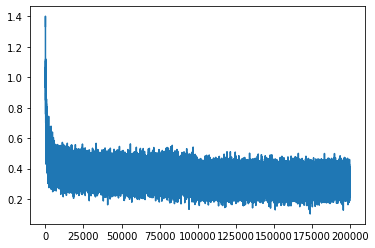

In [47]:
plt.plot(stepi, lossi);

In [48]:
# training loss
loss_fn(params, Xtr, Ytr, key)

DeviceArray(2.1563854, dtype=float32)

In [49]:
# validation loss
loss_fn(params, Xdev, Ydev, key)

DeviceArray(3.8459513, dtype=float32)

In [50]:
# Test loss
loss_fn(params, Xte, Yte, key)

DeviceArray(5.046379, dtype=float32)

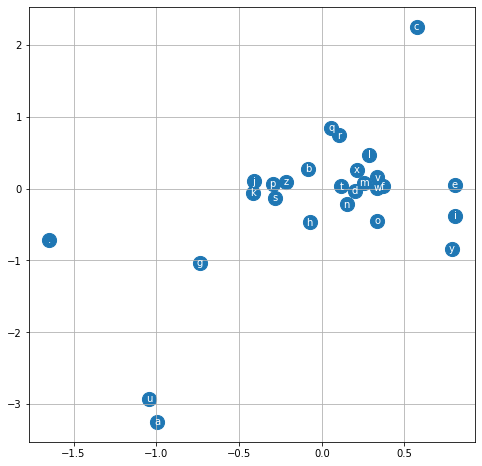

In [51]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(params["C"][:,0], params["C"][:,1], s=200)
for i in range(params["C"].shape[0]):
    plt.text(params["C"][i,0], params["C"][i,1], itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [52]:
# sample from the model
# g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      new_key, subkey = random.split(key)
      del key
      emb = params["C"][jnp.array([context])] # (1,block_size,d)
      h = jnp.tanh(jnp.matmul(emb.reshape(-1, 30), params["W1"]) + params["b1"]) # (32, 100)
      logits = h @ params["W2"] + params["b2"]
      ix = jax.random.categorical(subkey, logits).item()
      del subkey
      key = new_key
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

rayloryah.
thone.
rennodison.
zey.
arie.
wacy.
zeg.
roline.
zer.
rowardont.
rodeta.
tpe.
merryon.
cam.
miloriel.
darneyla.
emima.
aan.
amadea.
bron.
